In [1]:
#Introduction

In [2]:
"""
This example shows how structured data is categorized, starting with a raw CSV file. Our data contain both numerical and categorical features. Use Keras preprocessing layers to normalize numerical features and vectorize categorical features.
"""

'\nThis example shows how structured data is categorized, starting with a raw CSV file. Our data contain both numerical and categorical features. Use Keras preprocessing layers to normalize numerical features and vectorize categorical features.\n'

In [3]:
#The dataset

In [4]:
"""
Our dataset is provided by the Cleveland Clinic Foundation for Heart Disease. It's a CSV file with 303 rows. Each row contains information about a patient (a sample), and each column describes an attribute of the patient (a feature). We use the features to predict whether a patient has a heart disease (binary classification).
"""

"\nOur dataset is provided by the Cleveland Clinic Foundation for Heart Disease. It's a CSV file with 303 rows. Each row contains information about a patient (a sample), and each column describes an attribute of the patient (a feature). We use the features to predict whether a patient has a heart disease (binary classification).\n"

In [6]:
#import the libraries

In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
# Preparing the data

In [9]:
# Let's download the data and load it into a Pandas dataframe:

In [10]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
dataframe = pd.read_csv(file_url)

In [11]:
#The dataset includes 303 samples with 14 columns per sample (13 features, plus the target label):

dataframe.shape

(303, 14)

In [12]:
#Here's a preview of a few samples:

dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [13]:
#The last column, "target", indicates whether the patient has a heart disease (1) or not (0).

#Let's split the data into a training and validation set:

val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 242 samples for training and 61 for validation


In [14]:
#Let's generate tf.data.Dataset objects for each dataframe:

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [15]:
# Each Dataset yields a tuple (input, target) where input is a dictionary of features and target is the value 0 or 1:

for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=51>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=140>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=299>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=173>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=1.6>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'reversible'>}
Target: tf.Tensor(0, shape=(), dtype=int64)


In [16]:
# now we batch the datasets:

train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [17]:
# Feature preprocessing with Keras layers

In [18]:
"""
 The following features are categorical features encoded as integers:

sex
cp
fbs
restecg
exang
ca
We will encode these features using one-hot encoding. We have two options here:

Use CategoryEncoding(), which requires knowing the range of input values and will error on input outside the range.
Use IntegerLookup() which will build a lookup table for inputs and reserve an output index for unkown input values.
For this example, we want a simple solution that will handle out of range inputs at inference, so we will use IntegerLookup().

We also have a categorical feature encoded as a string: thal. We will create an index of all possible features and encode output using the StringLookup() layer.

Finally, the following feature are continuous numerical features:

age
trestbps
chol
thalach
oldpeak
slope
For each of these features, we will use a Normalization() layer to make sure the mean of each feature is 0 and its standard deviation is 1.
"""

'\n The following features are categorical features encoded as integers:\n\nsex\ncp\nfbs\nrestecg\nexang\nca\nWe will encode these features using one-hot encoding. We have two options here:\n\nUse CategoryEncoding(), which requires knowing the range of input values and will error on input outside the range.\nUse IntegerLookup() which will build a lookup table for inputs and reserve an output index for unkown input values.\nFor this example, we want a simple solution that will handle out of range inputs at inference, so we will use IntegerLookup().\n\nWe also have a categorical feature encoded as a string: thal. We will create an index of all possible features and encode output using the StringLookup() layer.\n\nFinally, the following feature are continuous numerical features:\n\nage\ntrestbps\nchol\nthalach\noldpeak\nslope\nFor each of these features, we will use a Normalization() layer to make sure the mean of each feature is 0 and its standard deviation is 1.\n'

In [19]:
""" 
Below, we define 3 utility functions to do the operations:

encode_numerical_feature to apply featurewise normalization to numerical features.
encode_string_categorical_feature to first turn string inputs into integer indices, then one-hot encode these integer indices.
encode_integer_categorical_feature to one-hot encode integer categorical features.
"""

' \nBelow, we define 3 utility functions to do the operations:\n\nencode_numerical_feature to apply featurewise normalization to numerical features.\nencode_string_categorical_feature to first turn string inputs into integer indices, then one-hot encode these integer indices.\nencode_integer_categorical_feature to one-hot encode integer categorical features.\n'

In [20]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [21]:
# Build a model

In [25]:
""" With this done, we can create our end-to-end model: """

' With this done, we can create our end-to-end model: '

In [26]:
# Categorical features encoded as integers
sex = keras.Input(shape=(1,), name="sex", dtype="int64")
cp = keras.Input(shape=(1,), name="cp", dtype="int64")
fbs = keras.Input(shape=(1,), name="fbs", dtype="int64")
restecg = keras.Input(shape=(1,), name="restecg", dtype="int64")
exang = keras.Input(shape=(1,), name="exang", dtype="int64")
ca = keras.Input(shape=(1,), name="ca", dtype="int64")

# Categorical feature encoded as string
thal = keras.Input(shape=(1,), name="thal", dtype="string")

# Numerical features
age = keras.Input(shape=(1,), name="age")
trestbps = keras.Input(shape=(1,), name="trestbps")
chol = keras.Input(shape=(1,), name="chol")
thalach = keras.Input(shape=(1,), name="thalach")
oldpeak = keras.Input(shape=(1,), name="oldpeak")
slope = keras.Input(shape=(1,), name="slope")

all_inputs = [
    sex,
    cp,
    fbs,
    restecg,
    exang,
    ca,
    thal,
    age,
    trestbps,
    chol,
    thalach,
    oldpeak,
    slope,
]

# Integer categorical features
sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)

# String categorical features
thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)

# Numerical features
age_encoded = encode_numerical_feature(age, "age", train_ds)
trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

all_features = layers.concatenate(
    [
        sex_encoded,
        cp_encoded,
        fbs_encoded,
        restecg_encoded,
        exang_encoded,
        slope_encoded,
        ca_encoded,
        thal_encoded,
        age_encoded,
        trestbps_encoded,
        chol_encoded,
        thalach_encoded,
        oldpeak_encoded,
    ]
)
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

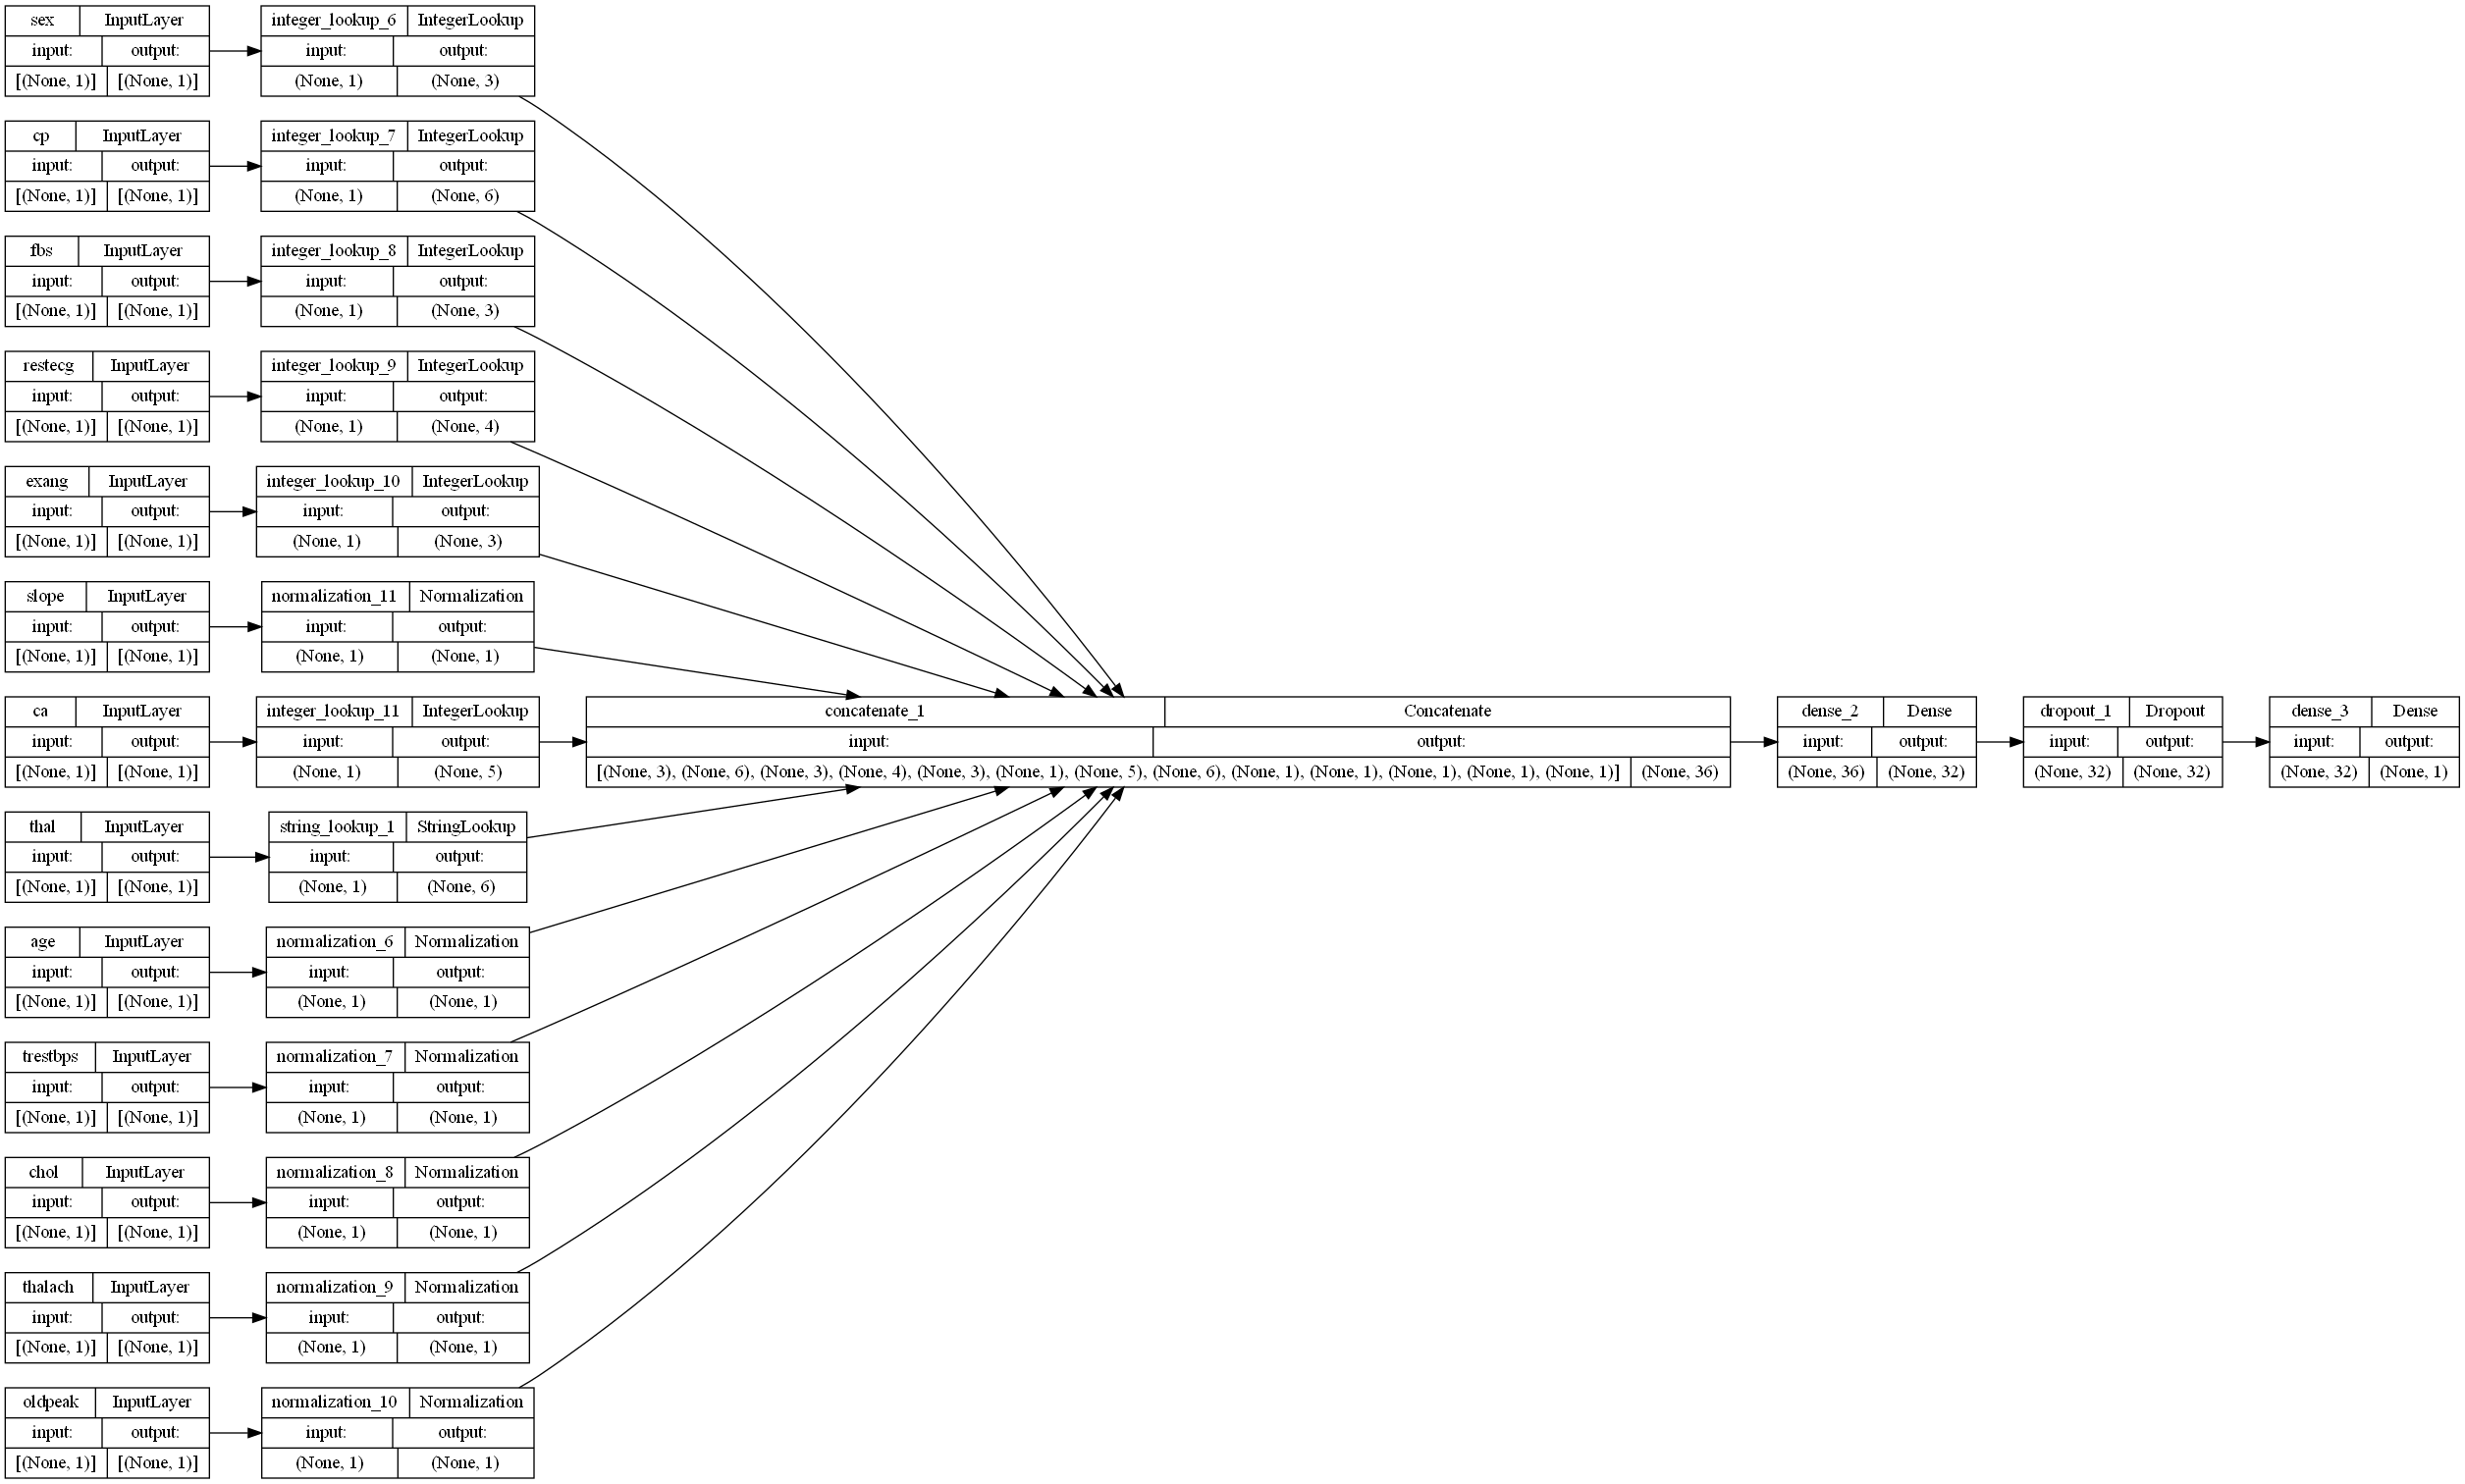

In [27]:
# Let's visualize our connectivity graph:

# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [28]:
#Train the model
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
8/8 [==============================] - 2s 120ms/step - loss: 0.6613 - accuracy: 0.6281 - val_loss: 0.5799 - val_accuracy: 0.6885
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.6580 - accuracy: 0.6405 - val_loss: 0.5437 - val_accuracy: 0.6885
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.6049 - accuracy: 0.6901 - val_loss: 0.5162 - val_accuracy: 0.7213
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 0.5949 - accuracy: 0.6983 - val_loss: 0.4942 - val_accuracy: 0.7541
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 0.5486 - accuracy: 0.7314 - val_loss: 0.4774 - val_accuracy: 0.7705
Epoch 6/50
8/8 [==============================] - 0s 7ms/step - loss: 0.5220 - accuracy: 0.7314 - val_loss: 0.4614 - val_accuracy: 0.7869
Epoch 7/50
8/8 [==============================] - 0s 7ms/step - loss: 0.4960 - accuracy: 0.7438 - val_loss: 0.4464 - val_accuracy: 0.7869
Epoch 8/50
8/8 [================

In [29]:
# We quickly get to 80% validation accuracy.

In [31]:
# Inference on new data
"""
To get a prediction for a new sample, you can simply call model.predict(). There are just two things you need to do:

- wrap scalars into a list so as to have a batch dimension (models only process batches of data, not single samples)
- Call convert_to_tensor on each feature
"""

'\nTo get a prediction for a new sample, you can simply call model.predict(). There are just two things you need to do:\n\n- wrap scalars into a list so as to have a batch dimension (models only process batches of data, not single samples)\n- Call convert_to_tensor on each feature\n'

In [33]:
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "This particular patient had a %.1f percent probability "
    "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
    )

1/1 [==============================] - 0s 459ms/step
This particular patient had a 22.6 percent probability of having a heart disease, as evaluated by our model.
